In [1]:
# import required modules
import numpy
import os
import random
import shutil
import json
from IPython.display import clear_output
from PIL import Image
import shapely.geometry
from matplotlib import image as mpimg
from matplotlib import pyplot as plt

In [2]:
# set directory paths
path_to_root = '../../../..'
DAM_DIR = os.path.join(path_to_root, 'data/imagery-6-7-2019/dam_images')
NOT_A_DAM_DIR = os.path.join(path_to_root, 'data/imagery-6-7-2019/not_a_dam_images')
OUTPUT_DIR = os.path.join(path_to_root, 'data/imagery-6-7-2019_cropped_test_subset')
os.mkdir(OUTPUT_DIR)
os.mkdir(os.path.join(OUTPUT_DIR, 'dam_images'))
os.mkdir(os.path.join(OUTPUT_DIR, 'not_a_dam_images'))
print('input dam directory:', DAM_DIR)
print('input not_a_dam directory:', NOT_A_DAM_DIR)
print('output directory:', OUTPUT_DIR)

input dam directory: ../../../../data/imagery-6-7-2019/dam_images
input not_a_dam directory: ../../../../data/imagery-6-7-2019/not_a_dam_images
output directory: ../../../../data/imagery-6-7-2019_cropped_test_subset


In [4]:
# set lists

# collect all files
all_filenames = []
for filename in os.listdir(DAM_DIR):
    all_filenames.append(filename)
for filename in os.listdir(NOT_A_DAM_DIR):
    all_filenames.append(filename)
print('original input')
print('total # of files:', len(all_filenames), '\n')

# remove _bb.png and .aux.xml files
image_filenames = []
for filename in all_filenames:
    if '_bb.png' in filename:
        continue
    elif '.aux.xml' in filename:
        continue
    elif '.json' in filename:
        continue
    else:
        image_filenames.append(filename)
print('removed _bb.png and .aux.xml files')
print('total # of files:', len(image_filenames))

original input
total # of files: 144945 

removed _bb.png and .aux.xml files
total # of files: 36236


In [7]:
# new size dimensions
original_size = 419
cropped_size = 300
ratio = original_size / cropped_size
other_ratio = cropped_size / original_size
size_diff = original_size - cropped_size + 1

In [8]:
# TEST ONLY -- DON'T RUN
# create subset of images 
import random
random_indexes = []
for i in range(8):
    random_indexes.append(random.randint(0, 36000))
image_filenames_subset = []
for index in random_indexes:
    image_filenames_subset.append(image_filenames[index])
print('subset: \n')
for filename in image_filenames_subset:
    print(filename)
    

subset: 

3147_clipped.png
75674_clipped.png
1065-1459_not_a_dam.png
122306_clipped.png
117205_clipped.png
101508_clipped.png
39738_clipped.png
109085_clipped.png


In [9]:
# loop
i = 0
for filename in image_filenames:
    
    # print iteration
    clear_output(wait = True)
    print('Progress:', i + 1, '/', len(image_filenames))
    i += 1
    
    # open image of dam
    if 'not_a_dam' in filename:
        filepath = os.path.join(NOT_A_DAM_DIR, filename)
    else:
        filepath = os.path.join(DAM_DIR, filename)
    image = Image.open(filepath)
        
    # crop to input dimensions and offset
    offset = random.randint(-(size_diff / 2), size_diff / 2)
    min_val = size_diff / 2 + offset
    max_val = original_size - size_diff / 2 + offset
    region = (min_val, min_val, max_val, max_val)
    cropped_image = image.crop(region)
    
    # save as png
    if 'not_a_dam' in filename:
        cropped_image.save(os.path.join(OUTPUT_DIR, 'not_a_dam_images', filename))
    else:
        cropped_image.save(os.path.join(OUTPUT_DIR, 'dam_images', filename))
        
    # collect metadata from input json
    json_filename = filename.replace('.png', '.json')
    if 'not_a_dam' in json_filename:
        json_filepath = os.path.join(NOT_A_DAM_DIR, json_filename)
    else:
        json_filepath = os.path.join(DAM_DIR, json_filename)
    with open(json_filepath, 'r') as json_file:
        input_metadata = json.load(json_file)
    gdal_coords = input_metadata['lng_lat_centroid']
    bbox_coords = input_metadata['pixel_bounding_box']
    in_x0 = bbox_coords[0] 
    in_x1 = bbox_coords[2]
    in_y1 = bbox_coords[1]
    in_y0 = bbox_coords[3]
    norm_x = (in_x1 + in_x0) / (original_size * 2)
    norm_y = (in_y1 + in_y0) / (original_size * 2)
    norm_w = (in_x1 - in_x0) / original_size
    norm_h = (in_y1 - in_y0) / original_size
    

    # adjust metadata for offset
    # 0 2 1 3
    out_norm_x = (norm_x * cropped_size - offset) / cropped_size
    out_norm_y = (norm_y * cropped_size - offset) / cropped_size
    out_norm_w = ratio * norm_w
    out_norm_h = ratio * norm_h
    out_x0 = int(cropped_size * (out_norm_x - out_norm_w / 2))
    out_x1 = int(cropped_size * (out_norm_x + out_norm_w / 2))
    out_y1 = int(cropped_size * (out_norm_x + out_norm_h / 2))
    out_y0 = int(cropped_size * (out_norm_x - out_norm_h / 2))
    
    # save metadata to output json and output label
    output_metadata = {'lng_lat_centroid':gdal_coords, 'pixel_bounding_box':[out_x0, out_y1, out_x1, out_y0]}
    #print(output_metadata)
    if 'not_a_dam' in json_filepath:
        json_output_filepath = os.path.join(OUTPUT_DIR, 'not_a_dam_images', json_filename)
        with open(json_output_filepath, 'w') as json_output:
            json.dump(output_metadata, json_output)
        with open(json_output_filepath.replace('.json', '.txt'), 'w') as label_output:
            output_str = '0 ' + str('%.6f'%out_norm_x) + ' ' + str('%.6f'%out_norm_y) + ' ' + str('%.6f'%out_norm_w) + ' ' + str('%.6f'%out_norm_h)
            label_output.write(output_str)
    else:
        json_output_filepath = os.path.join(OUTPUT_DIR, 'dam_images', json_filename)
        with open(json_output_filepath, 'w') as json_output:
            json.dump(output_metadata, json_output)
        with open(json_output_filepath.replace('.json', '.txt'), 'w') as label_output:
            output_str = '0 ' + str('%.6f'%out_norm_x) + ' ' + str('%.6f'%out_norm_y) + ' ' + str('%.6f'%out_norm_w) + ' ' + str('%.6f'%out_norm_h)
            label_output.write(output_str)

Progress: 61 / 36236


KeyboardInterrupt: 

../../../../data/imagery-6-7-2019/dam_images/2569_clipped.json
../../../../data/imagery-6-7-2019_cropped/dam_images/2569_clipped.json
../../../../data/imagery-6-7-2019/dam_images/13769_clipped.json
../../../../data/imagery-6-7-2019_cropped/dam_images/13769_clipped.json
../../../../data/imagery-6-7-2019/dam_images/59491_clipped.json
../../../../data/imagery-6-7-2019_cropped/dam_images/59491_clipped.json
../../../../data/imagery-6-7-2019/dam_images/114425_clipped.json
../../../../data/imagery-6-7-2019_cropped/dam_images/114425_clipped.json
../../../../data/imagery-6-7-2019/dam_images/101374_clipped.json
../../../../data/imagery-6-7-2019_cropped/dam_images/101374_clipped.json
../../../../data/imagery-6-7-2019/dam_images/112773_clipped.json
../../../../data/imagery-6-7-2019_cropped/dam_images/112773_clipped.json
../../../../data/imagery-6-7-2019/dam_images/47748_clipped.json
../../../../data/imagery-6-7-2019_cropped/dam_images/47748_clipped.json
../../../../data/imagery-6-7-2019/dam_images

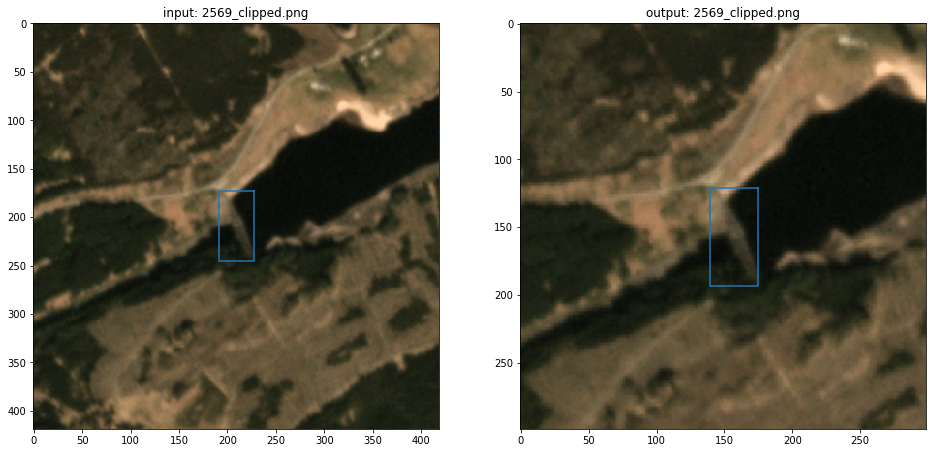

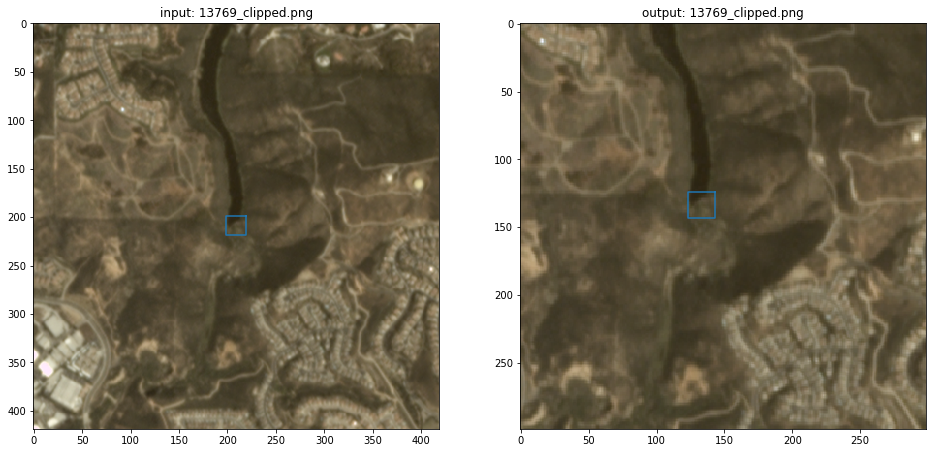

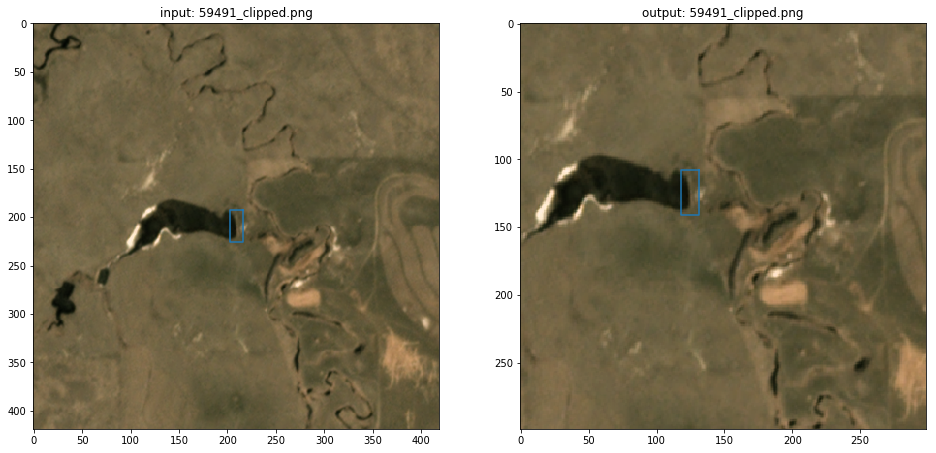

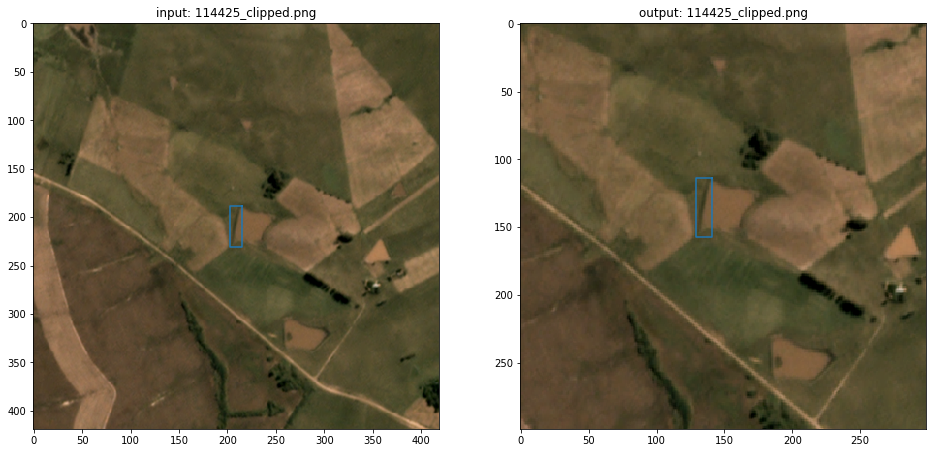

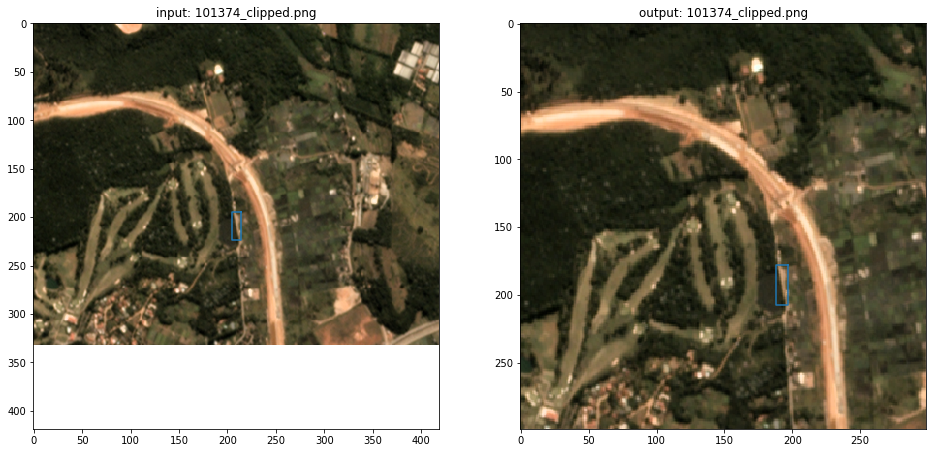

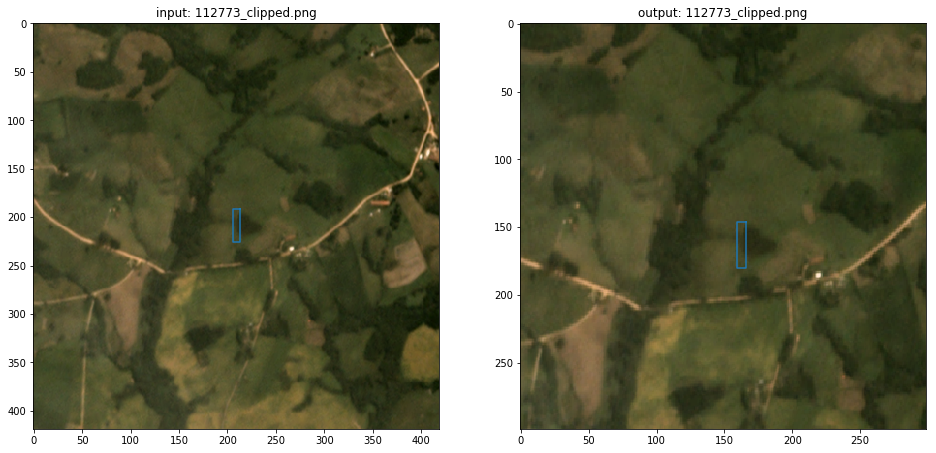

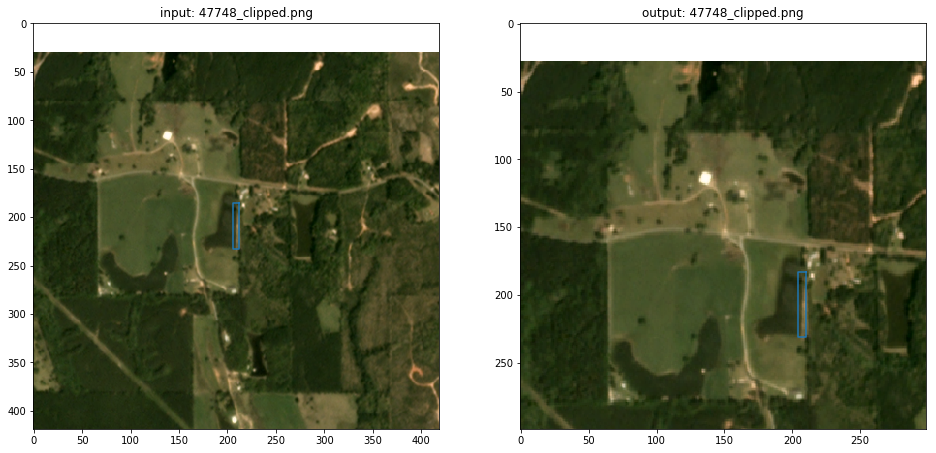

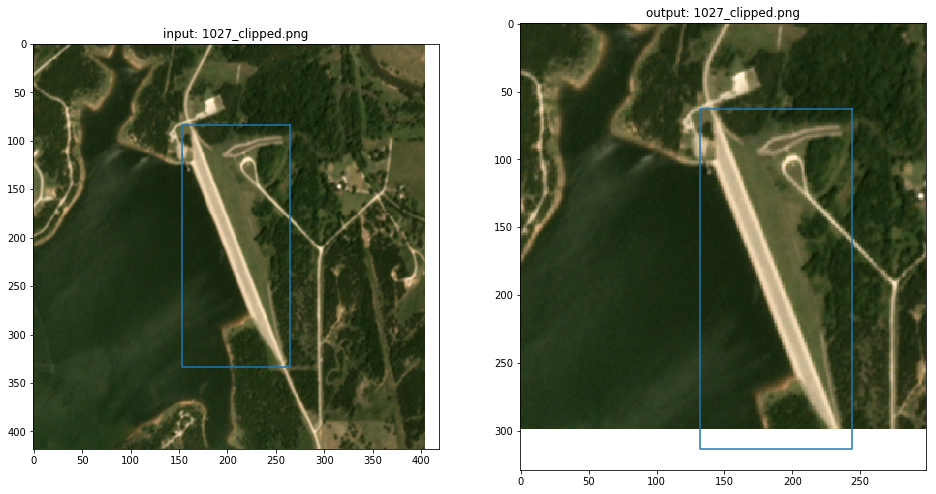

In [11]:
# visualize for debug purposes

# set directory paths and lists
OUTPUT_DAM = os.path.join(os.path.join(OUTPUT_DIR, 'dam_images'))
OUTPUT_NOT_A_DAM = os.path.join(os.path.join(OUTPUT_DIR, 'not_a_dam_images'))
filenames = os.listdir(OUTPUT_DAM) + os.listdir(OUTPUT_NOT_A_DAM)
image_filenames = []
for filename in filenames:
    if '.json' not in filename:
        if '.txt' not in filename:
            image_filenames.append(filename)

# visualize
for filename in image_filenames[:8]:
    
    # collect input image and json
    json_filename = filename.replace('.png', '.json')
    if 'not_a_dam' in filename:
        input_image_path = os.path.join(NOT_A_DAM_DIR, filename)
        input_image = mpimg.imread(input_image_path)
        input_json_path = os.path.join(NOT_A_DAM_DIR, json_filename)
    else:
        input_image_path = os.path.join(DAM_DIR, filename)
        input_image = mpimg.imread(input_image_path)
        input_json_path = os.path.join(DAM_DIR, json_filename)
        
    # collect output image and json
    output_image_path = input_image_path.replace('imagery-6-7-2019', 'imagery-6-7-2019_cropped')
    output_image = mpimg.imread(output_image_path)
    output_json_path = os.path.join(output_image_path.replace('.png', '.json'))
    print(input_json_path)
    print(output_json_path)
    
    # collect json metadata
    with open(input_json_path, 'r') as input_json:
        input_json_metadata = json.load(input_json)
        input_coords = input_json_metadata['pixel_bounding_box']
        input_bbox = shapely.geometry.box(input_coords[0], input_coords[3], input_coords[2], input_coords[1])
        in_x, in_y = input_bbox.exterior.xy
    with open(output_json_path, 'r') as output_json:
        output_json_metadata = json.load(output_json)
        output_coords = output_json_metadata['pixel_bounding_box']
        output_bbox = shapely.geometry.box(output_coords[0], output_coords[3], output_coords[2], output_coords[1])
        out_x, out_y = output_bbox.exterior.xy
        
    # visualize
    fig = plt.figure(figsize=(16, 96))
    ax1 = fig.add_subplot(8, 2, 1)
    ax1.set_title('input: ' + filename)
    ax1.imshow(input_image)
    ax1.plot(in_x, in_y)
    ax2 = fig.add_subplot(8, 2, 2)
    ax2.set_title('output: ' + filename)
    ax2.imshow(output_image)
    ax2.plot(out_x, out_y)

plt.show()